## Intro to language modeling: building makemore
### Part 3: Activations & Gradients, BatchNorm

From YouTube video: https://www.youtube.com/watch?v=P6sfmUTpUmc by @AndrejKarpathy

#### Library imports

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
# build the vocab of characters and mappings to int
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset

block_size = 3 # context len: 
# how many chars do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size # padded
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop & append
            # rolling window of context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [15]:
# MLP revisited
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # num of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/((n_embd * block_size)**0.5)) #kaiming_init # *0.2 -> std = 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
# cause there are too many variations for the logits
# I scale down the W2 (to 0.01) and
# set the b2 to be 0 at initialization

# batch normalization gain
bngain = torch.ones((1, n_hidden))
bnbias = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # num of params in total
for p in parameters:
    p.requires_grad = True

12297


In [16]:
# tanh --> 5/3
# std = gain/sqrt(fan_mode)
(5/3) / ((n_embd * block_size)**0.5)

0.3042903097250923

tensor(-0.0024) tensor(0.9983)
tensor(0.0026) tensor(0.9819)


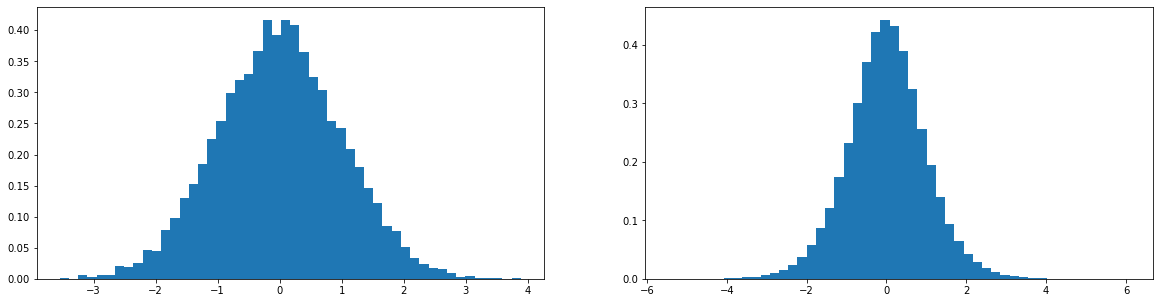

In [17]:
x = torch.randn(1000, 10)
# w = torch.randn(10, 200) * (num<1) # smaller and shrinking
# divided by the sqrt of fan_in / the num of input
w = torch.randn(10, 200) / (10**0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [18]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # Normalizing the pre act during initialization
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # outer layer
    loss = F.cross_entropy(logits, Yb) # loss func
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step lr decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3401
  10000/ 200000: 2.2846
  20000/ 200000: 2.3284
  30000/ 200000: 2.5253
  40000/ 200000: 1.9592
  50000/ 200000: 2.5090
  60000/ 200000: 2.3124
  70000/ 200000: 2.0885
  80000/ 200000: 2.3997
  90000/ 200000: 2.1687
 100000/ 200000: 1.9234
 110000/ 200000: 2.3111
 120000/ 200000: 1.9855
 130000/ 200000: 2.5203
 140000/ 200000: 2.3358
 150000/ 200000: 2.2478
 160000/ 200000: 2.0123
 170000/ 200000: 1.8866
 180000/ 200000: 1.9666
 190000/ 200000: 1.8665


In [9]:
# ----- Fixing the initial loss ----- #

# 0/ 200000: 28.4138
# from the probability of uniform distribution
# I should expect the prob of each char to be 1/27
-torch.tensor(1/27.0).log()
# so my first round has fake confidence

tensor(3.2958)

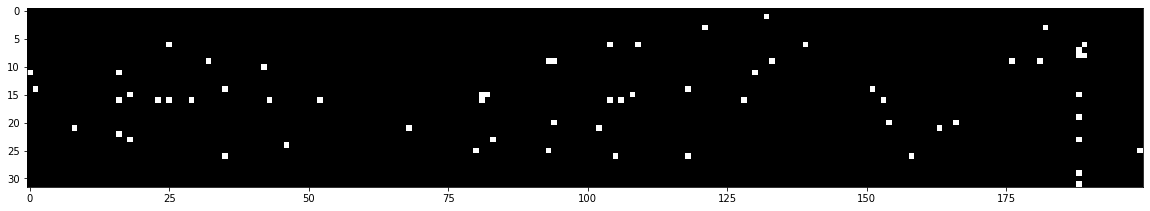

In [56]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# h.abs() > 0.99 is a boolean tensor
# if the entire column of the neuron is white, it's dead

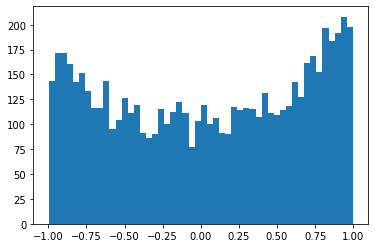

In [57]:
# ----- Fixing the saturated tanh ----- #
# # some visualization
plt.hist(h.view(-1).tolist(), 50);
# the histogram has extreme weights on -1 and 1

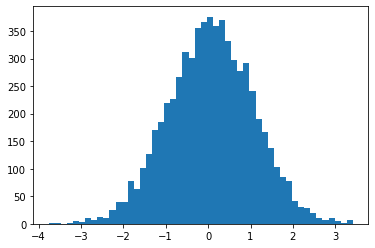

In [58]:
plt.hist(hpreact.view(-1).tolist(), 50);
# the histogram is very very broad

In [59]:
# prefer hpreact to be closer to 0
# b1 * 0.01 ---> can still have some entropy

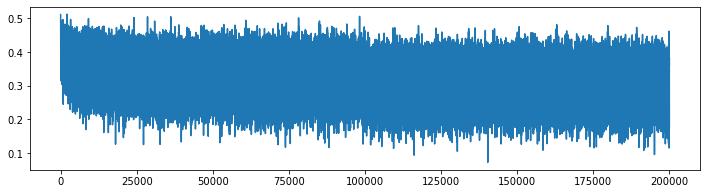

In [61]:
plt.figure(figsize=(12,3))
plt.plot(lossi)

In [19]:
@torch.no_grad() # this decorator disables gradient tracking
# more efficient <--- making grad = False
# much faster <--- telling it I won't have a backward func
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0668179988861084
val 2.111778974533081


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all..
    while True:
        # forward pass the nn
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khi.
miliathtyn.
kansh.
esrahnel.
amerynch.
aqui.
ner.
keah.
maiiven.
leigh.
ham.
jorn.
quint.
saline.
liveni.
wazelo.
dearynix.
kael.
